In [6]:
from new_tools import reward, no_collision
import numpy as np
from Adaptor import Adaptor_rte
import math

In [7]:
baseline = np.load("filtered_baseline.npy")
case = np.load("f=0.85_s=0.9_dmg1.npy")
adaptor_rte = Adaptor_rte(v=0.5)

In [8]:
# RTE
state_x = 0
state_y = 0
state_theta = 1
# state_theta = 0
outcomes = np.zeros((len(baseline), 2), dtype=np.float32)

budget = 50

positions = np.zeros((budget + 1, 2), dtype=np.float32)
positions[0] = state_x, state_y
complete_index = budget

for i in range(budget):
    R_matrix = np.array([
        [math.cos(state_theta), -math.sin(state_theta)],
        [math.sin(state_theta), math.cos(state_theta)]
    ], dtype=np.float32)

    # predicted_x, predicted_y = adaptor_rte.predict(baseline[:, :2])

    # predicted_x, predicted_y = baseline[:, :2].T # baseline
    predicted_x, predicted_y = case[:, :2].T # damage
    predicted_x = predicted_x.reshape(-1, 1)
    predicted_y = predicted_y.reshape(-1, 1)
    # print(predicted_x.shape)

    outcomes[:, 0] = predicted_x[:, 0]
    outcomes[:, 1] = predicted_y[:, 0]
    outcomes = outcomes @ R_matrix.T
    outcomes[:, 0] += state_x
    outcomes[:, 1] += state_y

    rewards = reward((state_x, state_y), outcomes)

    next_action_index = np.argmax(rewards)
    # print(outcomes[next_action_index])
    # print(next_action_index)

    true_x , true_y, true_v, true_w, true_phi = case[next_action_index]
    # true_x , true_y, true_v, true_w, true_phi = baseline[next_action_index]

    step_data = np.zeros((2, 3))
    step_data[:, 0] = baseline[next_action_index, 0]
    step_data[:, 1] = baseline[next_action_index, 1]
    step_data[0, 2] = true_x - baseline[next_action_index, 0]
    step_data[1, 2] = true_y - baseline[next_action_index, 1]
    adaptor_rte.read_data(step_data)


    new_x = math.cos(state_theta)*true_x - math.sin(state_theta)*true_y + state_x
    new_y = math.sin(state_theta)*true_x + math.cos(state_theta)*true_y + state_y


    if no_collision((state_x, state_y), (new_x, new_y)):
        state_x = new_x
        state_y = new_y
        state_theta += 4*true_w
    elif not ((-2.09 < state_y < 14.09 and state_x < 22.09) and (not (2.09 < state_y < 12.91 and state_x < 20.41))):
        print(state_x, state_y)
        # print(no_collision((state_x, state_y), (state_x, state_y)))
        raise Exception("out of arena")
    else:
        print("here", i+1)
    
    positions[i + 1] = state_x, state_y

    if state_y > 12.91 and state_x < 0:
        print("early complete:", i+1, "steps" if i else "step")
        complete_index = i + 1
        break








# rte_adaptation = np.zeros((100, 26), dtype=np.float32)
# for round_index in range(100):
#     adaptor_rte = Adaptor_rte(v=0.5)
#     errors = np.zeros(26)
#     step_taken = steps_taken[round_index]

#     for i, index in enumerate(step_taken):
#         if i:
#             step_data = np.zeros((2, 3))
#             step_data[:, 0] = baseline[index, 0]
#             step_data[:, 1] = baseline[index, 1]
#             step_data[0, 2] = case[index, 0] - baseline[index, 0]
#             step_data[1, 2] = case[index, 1] - baseline[index, 1]
#             adaptor_rte.read_data(step_data)
            
#         predicted_x, predicted_y = adaptor_rte.predict(baseline[:, :2])
#         errors[i] = np.mean(np.square(predicted_x[:, 0] - true_x) + np.square(predicted_y[:, 0] - true_y))
#     rte_adaptation[round_index] = errors

# print(rte_adaptation.shape)
# np.save(f"rte_case{case_index}.npy", rte_adaptation)

early complete: 17 steps


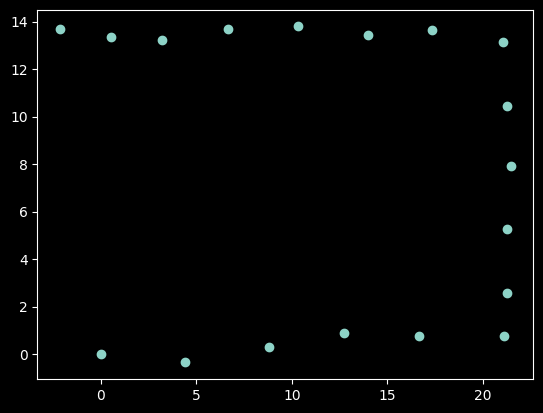

In [9]:
import matplotlib.pyplot as plt

plt.scatter(positions[:complete_index+1, 0], positions[:complete_index+1, 1])
plt.show()

In [10]:
print(positions[:complete_index])

[[ 0.          0.        ]
 [ 4.428819   -0.35200644]
 [ 8.821344    0.31438217]
 [12.730658    0.89847934]
 [16.680431    0.7462041 ]
 [21.123116    0.7761509 ]
 [21.257921    2.5758135 ]
 [21.255054    5.253453  ]
 [21.46704     7.9226894 ]
 [21.278849   10.4569435 ]
 [21.08253    13.127378  ]
 [17.323217   13.639283  ]
 [13.982207   13.420237  ]
 [10.316759   13.795574  ]
 [ 6.6340284  13.67776   ]
 [ 3.1773362  13.207402  ]
 [ 0.5035958  13.351876  ]]
